MQTT Broker (localhost)?  ee-raspi1001
MQTT username:  
 ········


creating new instance
connecting to broker
Subscribing to topic mqtt-sqlite-logger/sql_status
Subscribing to topic jupyterlab/sql_query_result
SQL Status received  SQL query successfull.
SQL Status received  SQL response published.


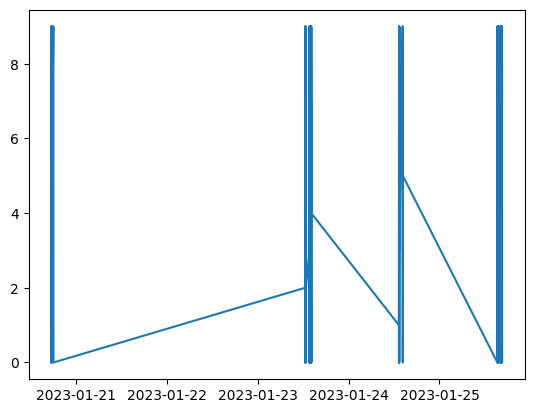

Program stopped.


In [17]:
"""
The programm can be used query the MQTT-SQLite-Logger database.
You can use this script with the Spyder IPython console.

Refer to README.md for more details.

Copyright 2023 GSI Helmholtzzentrum für Schwerionenforschung GmbH
Dr. Holger Brand, EEL, Planckstraße 1, 64291 Darmstadt, Germany
eMail: H.Brand@gsi.de
Web: https://www.gsi.de/work/forschung/experimentelektronik/kontrollsysteme

Licensed under the EUPL. Refer to license files on disc.
"""

import getpass
import datetime
import json
import paho.mqtt.publish as publish
import matplotlib.pyplot as plt
import paho.mqtt.client as mqtt  # import the client
import time


def on_message(client, userdata, message):
    """Handle received MQTT topic."""
    try:
        payload = message.payload.decode("utf-8")
        if message.topic.find('sql_status') >= 0:
            print("SQL Status received ", payload)
            pass
        else:
            # print("SQL Results received ", payload)
            sql_query_result = json.loads(payload)
            # print('sql_query_result:', sql_query_result['sql_query_result'])
            data_times = []
            data_values = []
            ii = 0
            for row in sql_query_result['sql_query_result']:
                data_times.append(datetime.datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S'))
                data_values.append(row[1])
                ii += 1
            # print('ii=', ii, 'len(t)=', len(data_times), 'len(v)=', len(data_values))
            plt.plot(data_times, data_values)
            plt.show()
            pass
        pass
    except Exception as e:
        print('Exception cought:', e)
        pass


broker = "localhost"
if broker == 'localhost':
    tmp = input('MQTT Broker (' + broker + ')? ')
    if tmp != '':
        broker = tmp
user = input('MQTT username: ')
if len(user) == 0:
    user = None
pwd = getpass.getpass()
if len(pwd) == 0:
    pwd = None
print("creating new instance")
client = mqtt.Client("jupiterlab")  # create new instance
if user is not None and pwd is not None:
    client.username_pw_set(username=user, password=pwd)
client.on_message = on_message  # attach function to callback
print("connecting to broker")
client.connect(broker)  # connect to broker
client.loop_start()  # start the loop
print("Subscribing to topic", "mqtt-sqlite-logger/sql_status")
client.subscribe("mqtt-sqlite-logger/sql_status")
print("Subscribing to topic", "jupyterlab/sql_query_result")
client.subscribe("jupyterlab/sql_query_result")
sql_query = {
    "sql_query": "select datetime, data from data where datetime>'2023-01-20 17:30:00' AND topic_id=(select topic_id from topics WHERE topic_name = 'mqtt-sqlite-generator/integer') ORDER BY datetime ASC",
    "sql_result_topic": "jupyterlab/sql_query_result"
    }
publish.single("mqtt-sqlite-logger/sql_query", json.dumps(sql_query), hostname=broker)
time.sleep(3)  # wait
client.loop_stop()  # stop the loop
print("Program stopped.")
